In [10]:
import glob
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

In [2]:
# Load the combined dataset
combined_df = pd.read_csv("data/combined.csv")

# Step 2: Prepare the Data
# Assume first column is wavelength, others are sample types (flour, corn starch, etc.)
wavelengths = combined_df.iloc[:, 0]
sample_data = combined_df.iloc[:, 1:]
sample_labels = sample_data.columns

In [3]:
# Transpose so each row is one sample, and columns are wavelengths
X = sample_data.T
X.columns = wavelengths
X.index.name = 'Sample'

# Create label vector from index
labels = X.index
X = X.reset_index(drop=True)

# Step 3: Normalize the Data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

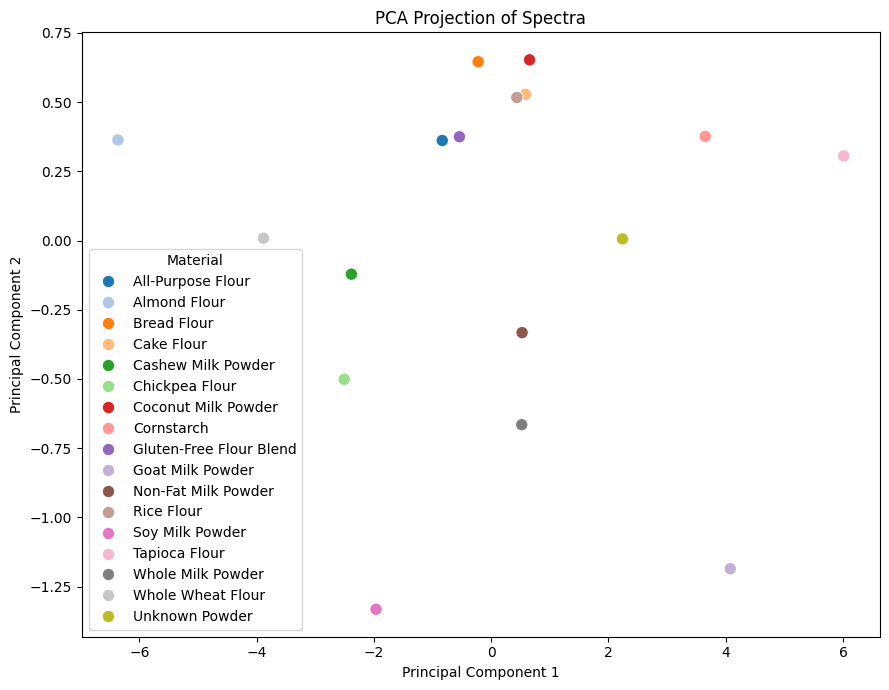

In [4]:
# Step 4: Reduce Dimensions for Visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Create a PCA projection which can show us a basic clustering of similar materials by spectra
plt.figure(figsize=(9, 7))
palette = sns.color_palette("tab20", n_colors=17)
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=labels, palette=palette, s=80)
plt.title("PCA Projection of Spectra")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title="Material")
plt.tight_layout()
plt.show()


In [5]:
# Step 5: Fit a Logistic Regression Model (linear classifier) which we can use to make predictions
model = LogisticRegression(max_iter=1000)
model.fit(X_scaled, labels)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,1000
,multi_class,'deprecated'


Training Accuracy: 0.82


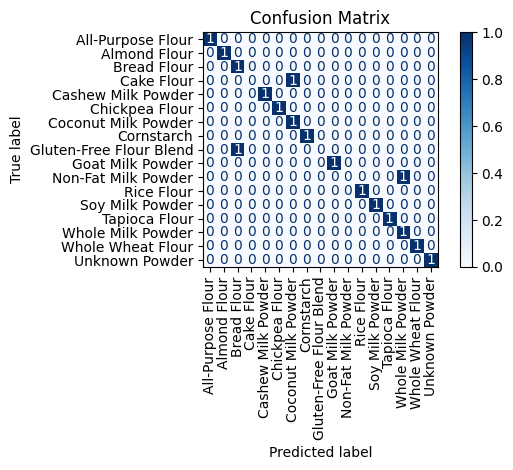

In [6]:
# Evaluate on same data (for demo purposes)
pred_labels = model.predict(X_scaled)
accuracy = accuracy_score(labels, pred_labels)
print(f"Training Accuracy: {accuracy:.2f}")

cm = confusion_matrix(labels, pred_labels, labels=labels.unique())
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels.unique()).plot(cmap="Blues", xticks_rotation=90)
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

In [7]:
# Step 6: Load Mystery Sample and Predict
mystery_df = pd.read_csv("data/MysteryPowder.csv")

# Make sure the sample is in the same format (just the intensity values)
mystery_sample = mystery_df.iloc[:, 1].values.reshape(1, -1)  # skip the wavelength column
mystery_scaled = scaler.transform(mystery_sample)


In [8]:
mystery_pred = model.predict(mystery_scaled)

print(f"\n🔍 The mystery sample is predicted to be: {mystery_pred[0]}")


🔍 The mystery sample is predicted to be: Tapioca Flour


In [37]:
# 🎓 Step 8: Analyze Student Samples
# Assume all student files are in the same directory and follow the format 'StudentName-Material.csv'
student_files = glob.glob("data/students/*.csv")
student_data = []
student_metadata = []

for file in student_files:
    filename = os.path.basename(file)
    
    try:
        name, material = filename.replace(".csv", "").split("-", 1)
        df = pd.read_csv(file)
        sample_values = df.iloc[:, 1].values  # assume second column is values
        student_data.append(sample_values)
        student_metadata.append({"Student": name, "Material": material})
    except Exception as e:
        print(f"Could not read {filename}: {e}")

In [38]:
student_df = pd.DataFrame(student_data)
student_meta_df = pd.DataFrame(student_metadata)

# Normalize and reduce dimensions
student_scaled = scaler.transform(student_df)
student_pca = pca.transform(student_scaled)

In [39]:
# Predict with trained model
student_predictions = model.predict(student_scaled)
student_meta_df["Predicted"] = student_predictions

In [40]:
# Show prediction and error comparison
student_meta_df["Correct"] = student_meta_df["Material"] == student_meta_df["Predicted"]
print("\nStudent Sample Predictions:")
print(student_meta_df)


Student Sample Predictions:
  Student     Material     Predicted  Correct
0     Bob  Bread_Flour  Almond Flour    False
1    Luna  Bread_Flour  Almond Flour    False
2    Luna   cornstarch    Rice Flour    False
3   Jenny  Bread_Flour  Almond Flour    False
4   Jenny   cornstarch    Rice Flour    False
5     Bob   cornstarch    Rice Flour    False


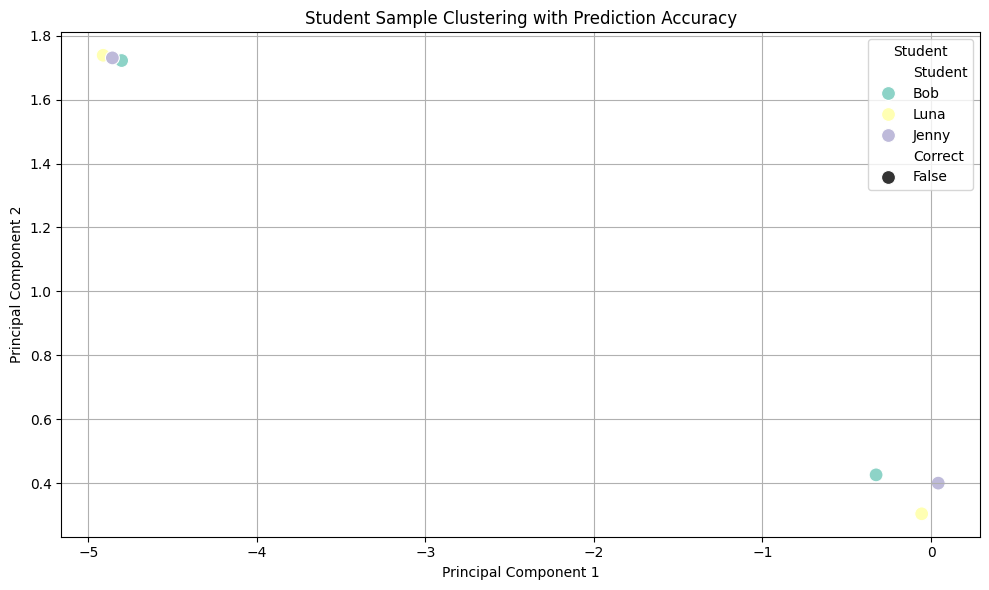

In [41]:
# Visualize clustering by student and prediction
plt.figure(figsize=(10, 6))
sns.scatterplot(x=student_pca[:, 0], y=student_pca[:, 1], hue=student_meta_df["Student"], style=student_meta_df["Correct"], palette="Set3", s=100)
plt.title("Student Sample Clustering with Prediction Accuracy")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title="Student")
plt.grid(True)
plt.tight_layout()
plt.show()
